# Project Goal: What attributes lead to best value university? 

# Steps: 

## 1) Define value metrics
#### Potentially:
1) high employment rate for grads n years after graduation <br>
2) high salary for grads n years after graduation (MN_EARN_WNE_P7 and/or MN_EARN_WNE_P9) - measured on previous cohort <br>
3) low debt (LO_INC_DEBT_MDN, MD_INC_DEBT_MDN, HI_INC_DEBT_MDN) or First Gen v. Not First Gen (FIRST_GEN_DEBT_MDN, NOTFIRSTGEN_DEBT_MDN)  <br>
4) debt default rate at 2 years or 3 years out (CDR2 & CDR3) <br> 
5) high completion percentage C150_4 (Also completion rates for different racial subgroups) <br> 
6) serves many first gen students (FIRST_GEN) 
7) Percentage completing within 4, 8 years at the original institution (COMP_ORIG_YR4_RT, COMP_ORIG_YR8_RT)

## 2) Control variables
#### Potentially: 
1) Baseline of incoming students <br>
    a) selectivity: ADM_RATE_ALL <br> 
    b) SAT scores: medians (SATVRMID & SATMTMID); means SAT_AVG_ALL - note: many nulls <br> 
2) Types of degrees awarded (percentage of technical degrees v arts type degrees
    a) PCIP 01, 03-05, 09-16, 19, 22-31, 38-52, 54<br> 
3) Geography? <br> 
4) Other student demographics? (family income? first year student) 

## 3) Variables of interest: 
#### Potentially: 
1) State or Region? (STABBR or REGION) <br> 
2) Public/Private Non-Profit/Private For-Profit (CONTROL) <br> 
3) Avg Cost Overall - AVGCOSTT4_A <br> 
4) Net Revenue per FT student - TUITFTE <br> 
5) Instruction Expenditures per Ft student - INEXPFTE


## 4) Other Limitations
#### Potentially: 
1) limit to Bachelors degrees 


## 5) Identify techniques
#### Potentially: 
1) Regressions <br> 
2) Clusters/Classifiers? - id which schools perform like schools in a different category <br> 
3) PCA? - probably not interpretable enough for our purposes 

## 6) Results?? 

In [279]:
import os, sys
import pandas as pd
import zipfile as zf
import requests

import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import urllib
import itertools
import pylab as pl
# import seaborn as sns

from __future__ import division

% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
try:
    df_2010 = pd.read_csv('Data/CollegeScorecard_Raw_Data/MERGED2010_11_PP.csv')
#If data not already downloaded, trigger download:
except: 
    url = 'https://ed-public-download.apps.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip'
    file_name = url.split('/')[-1]
    r = requests.get(url)
    with open(file_name, "wb") as code:
        code.write(r.content)
    zipref = zf.ZipFile(file_name, 'r')
    zipref.extractall('Data')
    zipref.close()
    try:
        df_2010 = pd.read_csv('Data\\CollegeScorecard_Raw_Data\\MERGED2010_11_PP.csv')
    except(IOError):
        df_2010 = pd.read_csv('Data/CollegeScorecard_Raw_Data/MERGED2010_11_PP.csv')

In [96]:
all_data = {}
for year in range(1997, 2011):
    all_data['df_{}'.format(year)] = pd.read_csv('Data/CollegeScorecard_Raw_Data/MERGED{}_{}_PP.csv'.format(year,str(year + 1)[2:4]))

In [5]:
# four-year institutions only
df_2010 = df_2010[df_2010.ICLEVEL == 1]

In [6]:
df_2010.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0


In [97]:
# DEBT_MDN = The median original amount of the loan principal upon entering repayment
subset_data = {}
for x in all_data.keys():
    subset_data['{}'.format(x)] = all_data['{}'.format(x)][['UNITID','DEBT_MDN']]
    subset_data['{}'.format(x)].rename(columns={'DEBT_MDN': '{}'.format(x[-4:])}, inplace=True)

In [98]:
subset_data['df_1997'][subset_data['df_1997']['1997'] == 'PrivacySuppressed'].count()

UNITID    1224
1997      1224
dtype: int64

In [99]:
subset_data['df_1997'][subset_data['df_1997']['1997'] != 'PrivacySuppressed']['1997'].dropna().astype(float).mean()

5456.673510065776

In [100]:
len(subset_data['df_1997'])

6699

In [225]:
dfsList = []
for x in subset_data.keys():
    dfsList.append(subset_data['{}'.format(x)])

In [304]:
df_final = reduce(lambda left, right: pd.merge(left, right, on='UNITID', how = 'inner'), dfsList)
df_final = df_final.replace(to_replace={'PrivacySuppressed':None}).dropna().set_index('UNITID')
df_final.shape

(3896, 14)

In [322]:
df_final = df_final.reindex_axis(sorted(df_final.columns),axis=1)

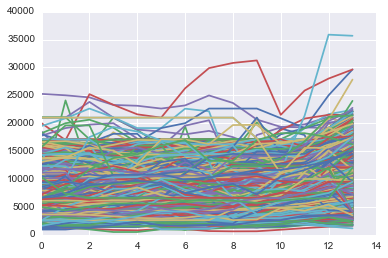

In [324]:
for i in df_final.index:
    pl.plot(df_final.loc[i])

In [325]:
nk= 5
centroids = cluster.k_means(np.asarray(df_final), 5, max_iter=15)[0]
labels = cluster.k_means(np.asarray(df_final), 5, max_iter=15)[1]

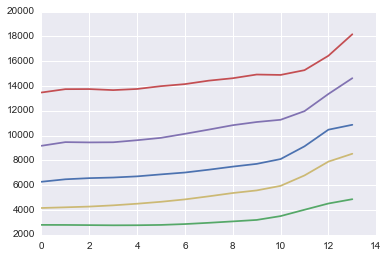

In [326]:
dates = list(range(1997, 2011))
cluster_centroidsDF = pd.DataFrame(centroids, columns = dates)

for i in range(0,5):
    pl.plot(cluster_centroidsDF.loc[i,dates])

In [366]:
cluster_myData = df_final.reset_index().join(pd.Series(data =labels, name = 'Cluster Number'))
cluster_myData = cluster_myData.set_index('UNITID')

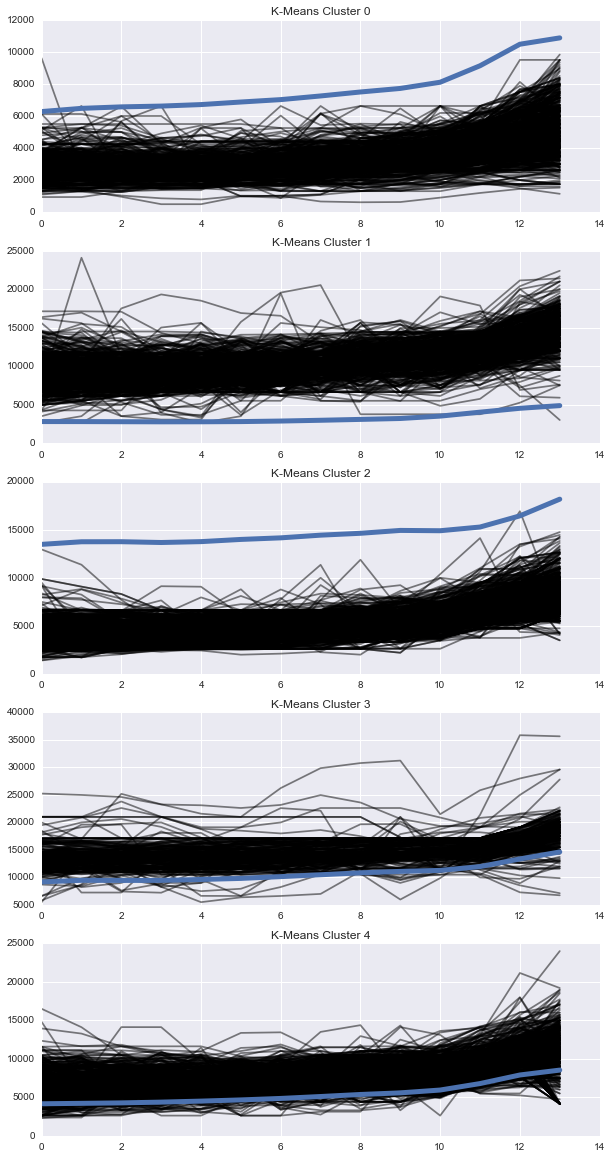

In [387]:
fig = pl.figure(figsize=(10,20))
ax = []
for i in range(0,5):
    ax.append(fig.add_subplot(5,1,i+1))
for i in df_final.index:
    cluster = int(cluster_myData.ix[i,'Cluster Number'])
    ax[cluster].plot(cluster_myData.ix[i,:-1],'k', alpha = 0.5)
for i in range(0,5):
    ax[i].plot(cluster_centroidsDF.loc[i], linewidth=5)
    ax[i].set_title('K-Means Cluster {}'.format(i))

In [390]:
int(cluster_myData.ix[100654,'Cluster Number'])

4